# Classify G20 mono vs. co-culture

### Test classification on G20 in mono- vs. co-culture only! (use only monoculture conditions in lactate)

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [3]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_alaskensis_G20_uid57941'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_ISB-1,Sample_ISB-1,Genewiz,SS01-ISB1,LS 37C G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.027
Sample_ISB-10,Sample_ISB-10,Genewiz,SS10-ISB10,PS 37C G20 e. stat 1,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035
Sample_ISB-11,Sample_ISB-11,Genewiz,SS11-ISB11,PS 37C G20 e. stat 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035


In [4]:
((info['organisms']=='D alskensis G20 and M maripaludis').values | 
 (info['organisms']=='D alskensis G20 and Methanospirillium hangeitii').values |
 (info['organisms']=='D. alaskensis G20').values) & (info['electron donor']=='lactate').values

array([ True, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False, False, False, False,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [5]:
info2 = info[((info['organisms']=='D alskensis G20 and M maripaludis').values | 
             (info['organisms']=='D alskensis G20 and Methanospirillium hangeitii').values |
             (info['organisms']=='D. alaskensis G20').values) & (info['electron donor']=='lactate').values]
print(info2.shape)
sizeme(info2,50,120)

(18, 16)


,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_ISB-1,Sample_ISB-1,Genewiz,SS01-ISB1,LS 37C G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.027
Sample_ISB-13,Sample_ISB-13,Genewiz,SS13-ISB13,LS 25 G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 25C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,25,D. alaskensis G20,0.000
Sample_ISB-14,Sample_ISB-14,Genewiz,SS14-ISB14,LS 25 G20 log 2,batch,NaN,"lactate 40mM, sulfate15mM 25C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,25,D. alaskensis G20,0.030
Sample_ISB-15,Sample_ISB-15,Genewiz,SS15-ISB15,LS 25 G20 log 3,batch,NaN,"lactate 40mM, sulfate15mM 25C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,25,D. alaskensis G20,0.000
Sample_ISB-16,Sample_ISB-16,Genewiz,SS16-ISB16,LS 25 G20 e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 25C",fermentation,lactate 10mM,lactate,10,none,0.001,25,D. alaskensis G20,0.000
Sample_ISB-17,Sample_ISB-17,Genewiz,SS17-ISB17,LS 25 G20 e. stat 2,batch,NaN,"lactate 40mM, sulfate15mM 25C",fermentation,lactate 10mM,lactate,10,none,0.001,25,D. alaskensis G20,0.050
Sample_ISB-18,Sample_ISB-18,Genewiz,SS18-ISB18,LS 25 G20 e. stat 3,batch,NaN,"lactate 40mM, sulfate15mM 25C",fermentation,lactate 10mM,lactate,10,none,0.001,25,D. alaskensis G20,0.000
Sample_ISB-2,Sample_ISB-2,Genewiz,SS02-ISB2,LS 37C G20 log 2,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.030
Sample_ISB-3,Sample_ISB-3,Genewiz,SS03-ISB3,LS 37C G20 log 3,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.001


### Identify groups of replicates in the measurements -- using groupby

In [6]:
info = info2
%Rpush info
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'T0C', 'organisms']
6 (18, 16) (6, 8)
[3, 3, 3, 4, 3, 2]
['Sample_ISB-4', 'Sample_ISB-5', 'Sample_ISB-6']
['Sample_ISB-13', 'Sample_ISB-14', 'Sample_ISB-15']
['Sample_ISB-1', 'Sample_ISB-2', 'Sample_ISB-3']
['Sample_UW1', 'Sample_UW2', 'Sample_UW3', 'Sample_UW4']
['Sample_ISB-16', 'Sample_ISB-17', 'Sample_ISB-18']
['Sample_UW5', 'Sample_UW6']


## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [7]:
x = all_freqs['Desulfovibrio_alaskensis_G20_uid57941'].copy()
print x.shape
cols = grouped.groups.values()[0]
xx = np.log10(x+1e-1).fillna( 0 )

(3369, 30)


In [8]:
%Rpush x
%Rpush info
%R colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))
#%R save(col_groups,file='qqq')

[1] 6


In [9]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))

[1] 6


In [11]:
%%R -n
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'organisms') {
        Y <- as.factor(as.character(info$organisms)=='D. alaskensis G20')
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    features <- character()
    B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0))
    if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    if (class(B.temp1a) == 'try-error' || length(features) < 2) {
        B.temp1a <- try(Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees*2, doTrace=0))
        if (class(B.temp1a) != 'try-error') features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
    }
        
    if (length(features) < 2) features <- rownames(XX)
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

NULL


In [12]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))
%R info2=subset(info, organisms%in%c('D alskensis G20 and M maripaludis','D alskensis G20 and Methanospirillium hangeitii','D. alaskensis G20') & electron.donor=='lactate')
%R info = info2; print(dim(info))
%R x.ranks = x.ranks[,gsub('.','-',colnames(x.ranks),fixed=T) %in% info$Sample.name]; print(dim(x.ranks))
#%R save(col_groups,file='qqq')
print col_groups

[1] 6


[1] 18 16


[1] 3369   18


[['Sample_ISB-4', 'Sample_ISB-5', 'Sample_ISB-6'], ['Sample_ISB-13', 'Sample_ISB-14', 'Sample_ISB-15'], ['Sample_ISB-1', 'Sample_ISB-2', 'Sample_ISB-3'], ['Sample_UW1', 'Sample_UW2', 'Sample_UW3', 'Sample_UW4'], ['Sample_ISB-16', 'Sample_ISB-17', 'Sample_ISB-18'], ['Sample_UW5', 'Sample_UW6']]


In [ ]:
%%R 
results = list()
for (cond_type in c('organisms')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- try(do_it(cond_type, x.ranks, cols, n_trees=2000))
        if (class(tmp) == 'try-error') tmp <- do_it(cond_type, x.ranks, cols, n_trees=1000)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}

In [22]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

organisms 
0.8333333 


organisms 
        2 


### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for 'organisms' conditions:

In [13]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
cond_type <- 'organisms'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
##for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- lapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- try(do_it(cond_type, xx, cols, n_trees=2000))
        if (class(ttmp) == 'try-error') ttmp <- do_it(cond_type, xx, cols, n_trees=1000)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    } )##, mc.preschedule=F )
    #print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean))
    return( tmp )
} )
#print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
qqq[[cond_type]] <- tmp_lst
##}

/home/dreiss/PYTHONUSERBASE/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in hitReg[hits] <<- hitReg[hits] + 1 : 
  NAs are not allowed in subscripted assignments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


1 of 6 99.8% 3362.264 7 organisms 
1 of 6 99.6% 3355.528 14 organisms 
1 of 6 99.4% 3347.792 21 organisms 
1 of 6 99.2% 3343 26 organisms 
1 of 6 99% 3335.64 34 organisms 
1 of 6 98.8% 3327.752 41 organisms 
1 of 6 98.6% 3320.848 48 organisms 
1 of 6 98.4% 3315.112 54 organisms 
1 of 6 98.2% 3309 59 organisms 
1 of 6 98% 3301 67 organisms 
1 of 6 96% 3232.28 135 organisms 
1 of 6 94% 3166.68 203 organisms 
1 of 6 92% 3092.12 270 organisms 
1 of 6 80% 2692 673 organisms 
1 of 6 75% 2526 842 organisms 
1 of 6 50% 1722 1682 organisms 
1 of 6 0% 32.5 3351 organisms 
2 of 6 99.8% 3362.264 7 organisms 
2 of 6 99.6% 3355.528 14 organisms 
2 of 6 99.4% 3349 20 organisms 
2 of 6 99.2% 3342.056 27 organisms 
2 of 6 99% 3335.32 34 organisms 
2 of 6 98.8% 3328.584 41 organisms 
2 of 6 98.6% 3321 47 organisms 
2 of 6 98.4% 3315.112 54 organisms 
2 of 6 98.2% 3308.752 61 organisms 
2 of 6 98% 3303.64 68 organisms 
2 of 6 96% 3234.28 135 organisms 
2 of 6 94% 3167.92 203 organisms 
2 of 6 92% 3099.12

NULL


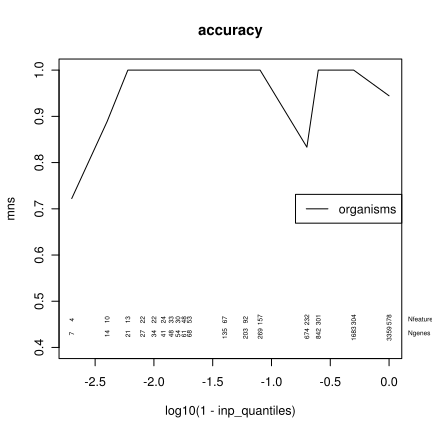

In [14]:
%%R
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
names(mns)<-names(qqq$organisms[[1]])
mns<-mns[length(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
names(n_features)<-names(qqq$organisms[[1]])
n_features<-n_features[length(n_features):1]

plot(log10(1-inp_quantiles),mns,typ='l',main='accuracy', ylim=c(0.4,1.0))
legend('right',legend=names(qqq),lwd=1,col=1:4)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.43, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.43, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.46, lab=as.character(round(n_features)),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.46, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

In [17]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
//var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [18]:
#%R save.image('qqq')
%Rpush NOTEBOOK_FULL_PATH
%R save.image(paste(gsub('ipynb','RData',NOTEBOOK_FULL_PATH)))

### Get list of (importance-ranked) genes for each condition...

### organisms (i.e., for G20, is it mono- or co-culture)

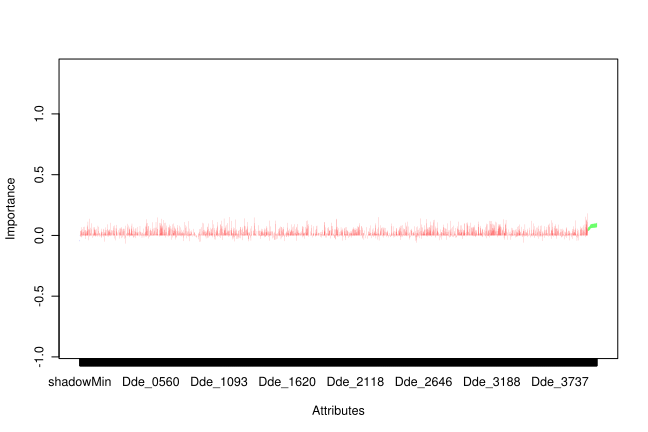

In [74]:
%%R -w 9
nlev = length(inp_quantiles)
tmp = table(unlist(lapply(qqq$organisms,function(i)i[[nlev]]$features)))
genes = names(tmp[tmp>=3])
Y <- as.factor(as.character(info$organisms)=='D. alaskensis G20')
#rf <- randomForest(t(x.ranks[genes,]), Y, importance=T, ntree=100000, do.trace=F)
#varImps = varImpPlot(rf) ##; print(rf)
#varImps = varImps[ order(varImps[,1], decreasing=T), ]
#imp_genes = rownames(varImps)[1:30]
b <- Boruta(t(x.ranks[genes,]), Y, getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b, border=NA)
imp_genes <- names(b$finalDecision)[which(b$finalDecision == 'Confirmed')]
imp_genes <- names(sort(apply(b$ImpHistory[,imp_genes],2,mean),decreasing=T))
imp_genes <- imp_genes[ ! imp_genes %in% c('shadowMax', 'shadowMean', 'shadowMin') ]

In [75]:
%Rpull imp_genes
print ' '.join(imp_genes)
query = '+OR+'.join(imp_genes)
query = 'http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery='+query
print query
from IPython.display import IFrame
IFrame(query, width='100%', height=250)

Dde_2265 Dde_0391 Dde_3709 Dde_3713 Dde_0725 Dde_0146 Dde_2575 Dde_3320 Dde_2108 Dde_3711 Dde_2560 Dde_2961 Dde_0371 Dde_2471 Dde_2972 Dde_1143 Dde_3710 Dde_1853 Dde_2928 Dde_0017 Dde_2871 Dde_3051 Dde_0682 Dde_3305 Dde_2930 Dde_0590 Dde_1656 Dde_1551 Dde_0717 Dde_3295 Dde_2335 Dde_3254 Dde_3752 Dde_R0080 Dde_1590 Dde_2699 Dde_2552 Dde_3029 Dde_3624 Dde_0987 Dde_2139 Dde_R0087 Dde_2610 Dde_3151 Dde_0254 Dde_3256 Dde_0499 Dde_3646 Dde_2152 Dde_3170 Dde_1519 Dde_2695 Dde_1360 Dde_3069 Dde_3444 Dde_0029 Dde_3675 Dde_2597
http://microbesonline.org/cgi-bin/keywordSearch.cgi?searchType=customQuery&customQuery=Dde_2265+OR+Dde_0391+OR+Dde_3709+OR+Dde_3713+OR+Dde_0725+OR+Dde_0146+OR+Dde_2575+OR+Dde_3320+OR+Dde_2108+OR+Dde_3711+OR+Dde_2560+OR+Dde_2961+OR+Dde_0371+OR+Dde_2471+OR+Dde_2972+OR+Dde_1143+OR+Dde_3710+OR+Dde_1853+OR+Dde_2928+OR+Dde_0017+OR+Dde_2871+OR+Dde_3051+OR+Dde_0682+OR+Dde_3305+OR+Dde_2930+OR+Dde_0590+OR+Dde_1656+OR+Dde_1551+OR+Dde_0717+OR+Dde_3295+OR+Dde_2335+OR+Dde_3254+OR+Dde_3

NULL


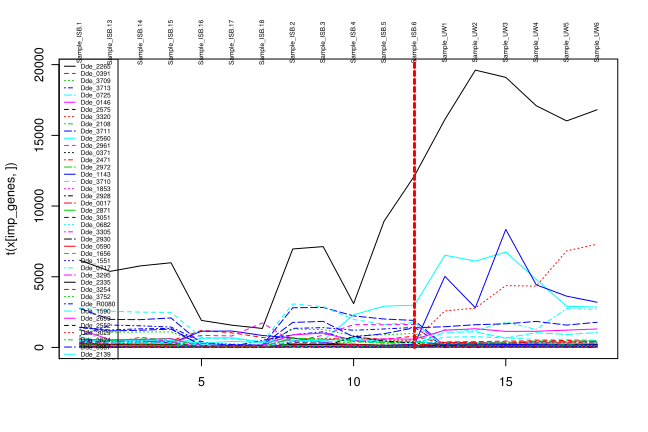

In [81]:
%%R -w 9
x = as.matrix(x[,colnames(x)%in%colnames(x.ranks)])
x = cbind(x[,Y==TRUE], x[,Y==FALSE])
#load('qqq')
matplot(t(x[imp_genes,]), typ='l')
legend('topleft', legend=imp_genes, cex=0.5, col=1:6, lty=1:5)
lines(rep(sum(Y==TRUE),2), c(0,99999), col='red', lty=2, lwd=3)
text(x=1:ncol(x), y=rep(max(x[imp_genes,])*1.1,ncol(x)),gsub('Sample_US.','',colnames(x)), srt=90, cex=0.5, xpd=NA)
NULL

NULL


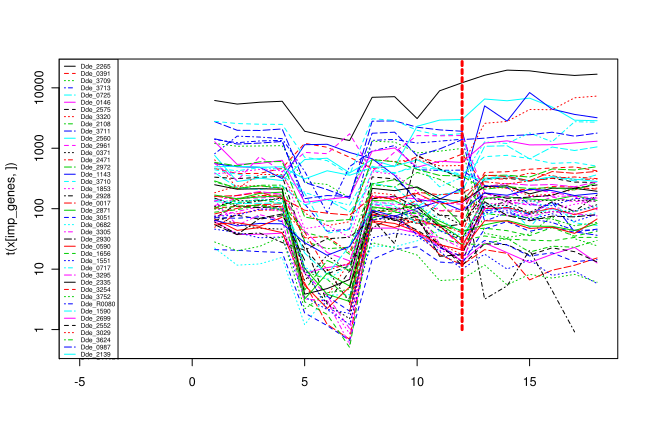

In [82]:
%%R -w 9
matplot(t(x[imp_genes,]), typ='l', log='y', xlim=c(-5, ncol(x)))
legend('topleft', legend=imp_genes, cex=0.5, col=1:6, lty=1:5)
lines(rep(sum(Y==TRUE),2), c(1,100000), col='red', lty=2, lwd=3)
NULL

[1] 3369   18
1.869158 1.901653 
0.7810519 0.5363503 

	Welch Two Sample t-test

data:  tmp1 and tmp2
t = -12.094, df = 45950, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.08928100 -0.06437802
sample estimates:
mean of x mean of y 
 1.832209  1.909039 

NULL


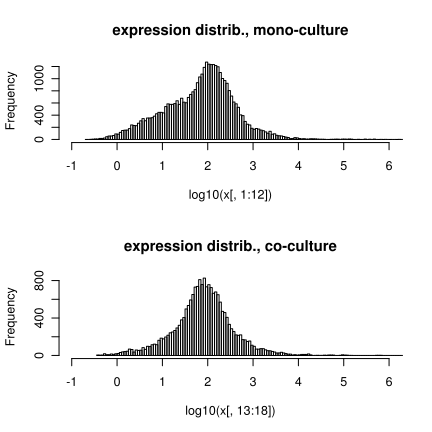

In [61]:
%%R
par(mfrow=c(2,1))
print(dim(x))
hist(log10(x[,1:12]),breaks=200, main='expression distrib., mono-culture', xlim=c(-1,6))
hist(log10(x[,13:18]),breaks=200, main='expression distrib., co-culture', xlim=c(-1,6))
cat(median(log10(x[,1:12])), median(log10(x[,13:18])), '\n')
cat(mad(log10(x[,1:12])), mad(log10(x[,13:18])), '\n')
tmp1=log10(x[, 1:12]);tmp1=tmp1[!is.infinite(tmp1)]
tmp2=log10(x[, 13:18]);tmp2=tmp2[!is.infinite(tmp2)]
print(t.test(tmp1,tmp2))
NULL

## Just for fun, see if randomizing the classes makes things worse:

[1] "Dde_0706"  "Dde_0693"  "Dde_0694"  "Dde_3214"  "Dde_0296"  "Dde_R0041"


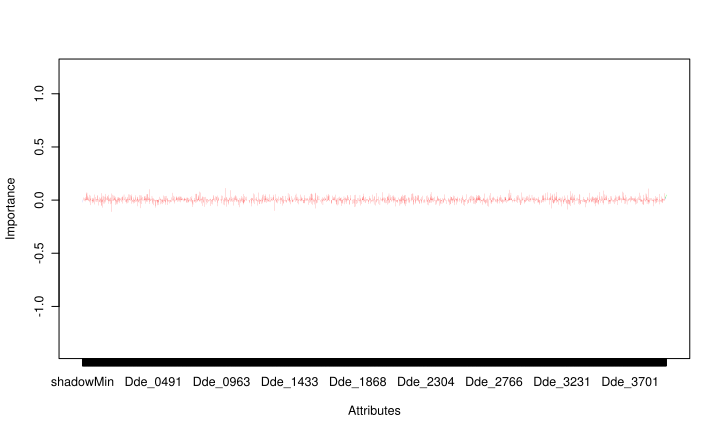

In [83]:
%%R -w 10
b_rnd <- Boruta(t(x.ranks[genes,]), sample(Y), getImp=getImpFerns, nferns=10000, maxRuns=5000)
plot(b_rnd, border=NA)
imp_genes_rnd <- names(b_rnd$finalDecision)[which(b_rnd$finalDecision == 'Confirmed')]
imp_genes_rnd <- names(sort(apply(b_rnd$ImpHistory[,imp_genes_rnd],2,mean),decreasing=T))
imp_genes_rnd <- imp_genes_rnd[ ! imp_genes_rnd %in% c('shadowMax', 'shadowMean', 'shadowMin') ]
print(imp_genes_rnd)